# Deep Learning Bootcamp - Final Data Challenge

As the final task of this bootcamp, the goal was to explore three different approaches to classify images of dogs and cats respectively. All of the deep learning models were done in **tensorflow.keras**.
For this project the chosen approaches were:
* CNN
* Transfer Learning with Xception based on the weights of ImageNet
* Transfer Learning with ResNet 50

In the following chapters each aproach will be further explained and the results will be evaluated.

At the start of the notebook, all the necessary imports are listed and then the datasets will be explored in order check if the dataset is balanced or not.

## Imports

In [1]:
## OS
import os

## Import json
import json

## Standard imports
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import time

## Tensorflow and Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.layers import LeakyReLU

## Set up of the dimensions of the images

The set up image dimensions are 128 pixels high and wide. Also there are three color channels. The color channels are red, blue and green.

In [3]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

## Directory to the the training_data

The data was previously divided by our teacher Dr. Claus Horn into a training and a validation data set. There are no further folder structures within the data sets. Therefore, the pictures are divided into the classes dogs and cats based on the picture name. After the split into the classes, the sizes will be compared 

In [4]:
filenames=os.listdir("raw_data/training_data")
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df_training_data=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [5]:
df_training_data.head()

,filename,category
0,cat.0.jpg,0
1,cat.1000.jpg,0
2,cat.10008.jpg,0
3,cat.10031.jpg,0
4,cat.10034.jpg,0


In [6]:
filenames=os.listdir("raw_data/training_data")
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append("Dog")
    else:
        categories.append("Cat")
df_training_data_histogram=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In the graph below we can see, that the training data set is pretty balanced.

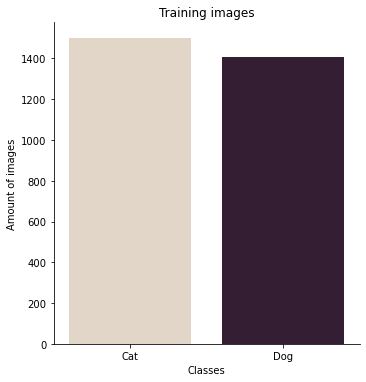

In [7]:
sns.catplot(x="category", kind="count", palette="ch:.25", data=df_training_data_histogram)
plt.xlabel('category')
plt.title("Training images")
plt.xlabel("Classes")
plt.ylabel("Amount of images")
plt.show()

In [8]:
filenames=os.listdir("raw_data/validation_data")
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df_validation_data=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [9]:
df_validation_data.head()

,filename,category
0,cat.10010.jpg,0
1,cat.10022.jpg,0
2,cat.10023.jpg,0
3,cat.10058.jpg,0
4,cat.10092.jpg,0


In [10]:
filenames=os.listdir("raw_data/validation_data")
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append("Dog")
    else:
        categories.append("Cat")
df_validation_data_histogram=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

The same can be said for the validation data set.

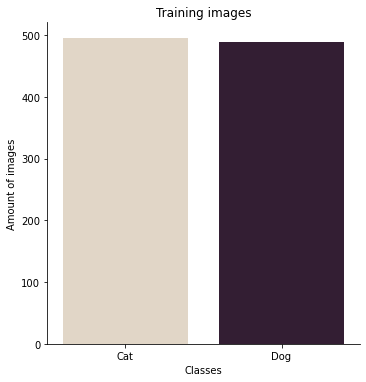

In [11]:
sns.catplot(x="category", kind="count", palette="ch:.25", data=df_validation_data_histogram)
plt.xlabel('category')
plt.title("Training images")
plt.xlabel("Classes")
plt.ylabel("Amount of images")
plt.show()

After the exploration of the datasets we can see, that the it is balanced and with that we can continue with getting the first model, to get a better understand of what could work and what not.

# CNN

The first experiment is executed with a CNN. This method has shown to be a good solution when dealing with images.

At the beginning we did just start out with a random model and did not augment the images before they were fed to the model. As can be seen further down, after the training of the model, the validation loss is more or less exploding after the tenth epochs.

In code cell below can be seen that the data from the training set, which was already set up, is split into training and validation sets.

The split ration is 80% training (2325 images) and 20% validation (582 images) and a batch size of 15 is defined. 

In [13]:
df_training_data["category"] = df_training_data["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df_training_data,test_size=0.20,random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]

In [ ]:
batch_size=15

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "raw_data/training_data/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='binary',
                                                 batch_size=batch_size)

Found 2325 validated image filenames belonging to 2 classes.


In [14]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "raw_data/training_data/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='binary',
    batch_size=batch_size)

Found 582 validated image filenames belonging to 2 classes.


What was initially labeled as validation data set, is now used as a test set. This was made so there was no further coding set needed.

In [14]:
df_validation_data["category"] = df_validation_data["category"].replace({0:'cat',1:'dog'})
test_df = df_validation_data
test_df = test_df.reset_index(drop=True)
total_test = test_df.shape[0]

In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                 "raw_data/validation_data/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='binary',
                                                 batch_size=batch_size)

Found 985 validated image filenames belonging to 2 classes.


In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width,Image_Height, Image_Channels)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)      

In [28]:
epochs=20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/20
155/155 [==============================] - 63s 402ms/step - loss: 0.6939 - accuracy: 0.4972 - val_loss: 0.6918 - val_accuracy: 0.5228
Epoch 2/20
155/155 [==============================] - 42s 272ms/step - loss: 0.6918 - accuracy: 0.5166 - val_loss: 0.6863 - val_accuracy: 0.5281
Epoch 3/20
155/155 [==============================] - 45s 291ms/step - loss: 0.6849 - accuracy: 0.5497 - val_loss: 0.6873 - val_accuracy: 0.5544
Epoch 4/20
155/155 [==============================] - 42s 270ms/step - loss: 0.6728 - accuracy: 0.5772 - val_loss: 0.6709 - val_accuracy: 0.5947
Epoch 5/20
155/155 [==============================] - 41s 266ms/step - loss: 0.6595 - accuracy: 0.6202 - val_loss: 0.6468 - val_accuracy: 0.6246
Epoch 6/20
155/155 [==============================] - 41s 267ms/step - loss: 0.6261 - accuracy: 0.6456 - val_loss: 0.6408 - val_accuracy: 0.6579
Epoch 7/20
155/155 [==============================] - 44s 282ms/step - loss: 0.6069 - accuracy: 0.6744 - val_loss: 0.6075 - val_ac

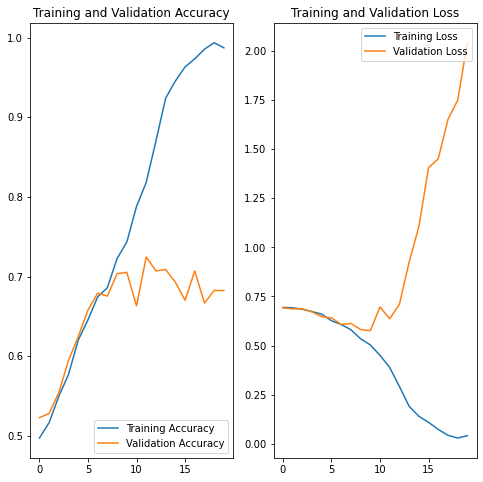

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

So it can be stated, that the first random guess did not work out. Because of that different adjustments were made. The training data will be augmented and the learning rate will be adjusted while training the model. The results look more promising. More details about the model can be seen below.

## Base model

In the model below worked as a baseline. First it was the goal to see if a achrchitecture, which worked previously in a different project, also for this one. It consists of one input layer, three hidden layers and one output layer. Each hidden layer and also the input layer use the ReLU activation function and MaxPooling. Also does each layer have a filter with the dimensions of 3 by 3. The neurons per layer increase from 32 to 128. At the end the values are flattened, so that the dense layers can be used. The first dense layer also uses a ReLU activation function. The last one uses a sigmoid function and consists of one neuron. With this the binary classification can be done.

Also as already mentioned that training data is augmented.

The model is then compiled with a binary crossentropy to calculate the loss and uses the adam optimizer. This optimizer has shown to be a good default choice.

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width,Image_Height,Image_Channels)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Below a summary of the first CNN can be seen.

In [152]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 12, 12, 128)     

Additionally to the explanation of the model before, below there are several things defined, while the model is trained. *Earlystop* is used, that if the model, does no improve over 10 epochs the training should stop. Additionally the *learning rate reduction* is used to adjust the learning rate, when the loss of the validation data does not improve. Once it does not improve for three or more epochs the learningrate will be multiplied by 0.5 and with that decreased.

In [153]:
earlystop = EarlyStopping(patience = 10, monitor="val_loss")
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

There the data from the default folder *training_data* is split into training and validation data frames. Also the batch size is defined to batch size is defined to 15.

## Data Augmentation

In those code cells the images for the training data is augmented. That means that the images are rescaled, zoomed in on, horizontally flimed and more. This should help to prevent over fitting, because the model has to incorpore many different variations and is foreced to generalized.

In [24]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "raw_data/training_data/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='binary',
                                                 batch_size=batch_size)

Found 2325 validated image filenames belonging to 2 classes.


In [25]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Below the images show how they are augmented.

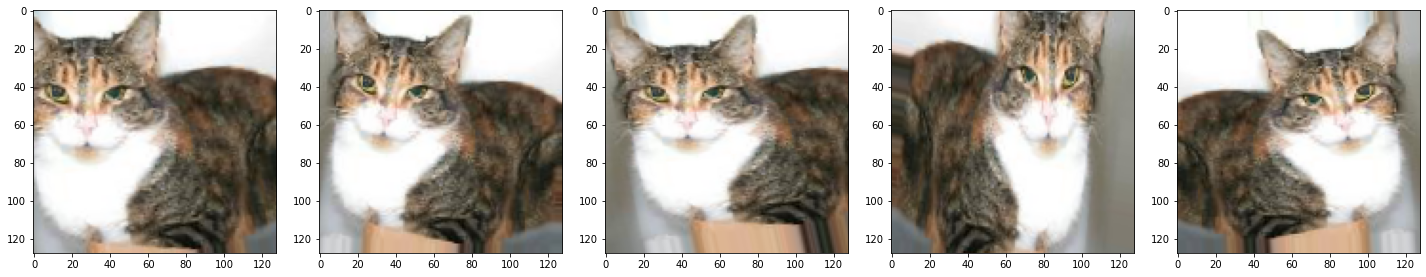

In [26]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

The validation data is simply rescaled, but not further augmented.

In [13]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "raw_data/training_data/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='binary',
    batch_size=batch_size
)

Found 582 validated image filenames belonging to 2 classes.


In [10]:
df_validation_data["category"] = df_validation_data["category"].replace({0:'cat',1:'dog'})
test_df = df_validation_data
test_df = test_df.reset_index(drop=True)
total_test = test_df.shape[0]
batch_size=15

For the test data the images from the validation data is used.

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                 "raw_data/validation_data/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='binary',
                                                 batch_size=batch_size,
                                                  shuffle=True)

Found 985 validated image filenames belonging to 2 classes.


Here the base model is trained for 20 epochs

In [161]:
epochs=20
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
155/155 [==============================] - 52s 335ms/step - loss: 0.6941 - accuracy: 0.5075 - val_loss: 0.6818 - val_accuracy: 0.5351
Epoch 2/20
155/155 [==============================] - 51s 331ms/step - loss: 0.6822 - accuracy: 0.5690 - val_loss: 0.6695 - val_accuracy: 0.5947
Epoch 3/20
155/155 [==============================] - 50s 324ms/step - loss: 0.6595 - accuracy: 0.6090 - val_loss: 0.6253 - val_accuracy: 0.6386
Epoch 4/20
155/155 [==============================] - 51s 325ms/step - loss: 0.6514 - accuracy: 0.6155 - val_loss: 0.6079 - val_accuracy: 0.6860
Epoch 5/20
155/155 [==============================] - 52s 333ms/step - loss: 0.6561 - accuracy: 0.6176 - val_loss: 0.6370 - val_accuracy: 0.6298
Epoch 6/20
155/155 [==============================] - 51s 330ms/step - loss: 0.6395 - accuracy: 0.6348 - val_loss: 0.6278 - val_accuracy: 0.6526
Epoch 7/20
155/155 [==============================] - 53s 338ms/step - loss: 0.6284 - accuracy: 0.6486 - val_loss: 0.6126 - val_ac

As we can see in the plots below the accuracy on the training and validation data increases steadily and the loss also decreases with more and more iterations. But the learning rate was automatically adjusted during the training of the model.

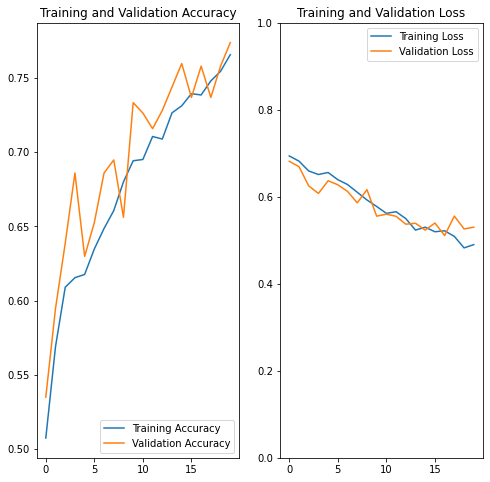

In [162]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.show()

Below the model will be saved.

In [163]:
model.save("models/base_line_catsVSdogs_20epoch.h5")

In [21]:
test_filenames = os.listdir("raw_data/validation_data")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [165]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

The base model achieves an accuracy of 76.95% on the training data. In the following parts of the notebook, the goal is to improve on that, but the chosen architecture works as a good first set up.

In [166]:
predict_evaluate = model.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))

66/66 [==============================] - 10s 148ms/step - loss: 0.5015 - accuracy: 0.7695


## Multiple models

In this chapter there are multiple architectures examinated. Below can be seen that different amount of neurons and hidden layers are looked at.

In [17]:
layer_sizes = [64,128,256] #
conv_layers = [2,3,4]

In [18]:
import datetime 
dt = datetime.datetime.now()

In [19]:
for layer_size in layer_sizes:
    for conv_layer in conv_layers:

        NAME = "{}-conv-{}-nodes-{}".format(conv_layer, layer_size, int(dt.strftime("%Y%m%d%H%M%S")))
        #tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
        print(NAME)

2-conv-64-nodes-20220219112148
3-conv-64-nodes-20220219112148
4-conv-64-nodes-20220219112148
2-conv-128-nodes-20220219112148
3-conv-128-nodes-20220219112148
4-conv-128-nodes-20220219112148
2-conv-256-nodes-20220219112148
3-conv-256-nodes-20220219112148
4-conv-256-nodes-20220219112148


There reason why the focus lies on the layer size and amount of hidden layers is, that all the models need a lot of time to run. There would have been other things to try, but due to limited computational power it was decided to mainly focus on the architecture.

In [22]:
for layer_size in layer_sizes:
    for conv_layer in conv_layers:

        NAME = "{}-conv-{}-nodes-{}".format(conv_layer, layer_size, int(dt.strftime("%Y%m%d%H%M%S")))
        tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
        earlystop = EarlyStopping(patience = 10, monitor="val_loss")
        learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.5,min_lr = 0.00001)
        callbacks = [earlystop,learning_rate_reduction, tensorboard]
        print(NAME)

        model = Sequential()
        model.add(Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width,Image_Height,Image_Channels)))
        model.add(MaxPooling2D(2,2))

        for l in range(conv_layer-1):
            model.add(Conv2D(layer_size, (3,3), activation='relu'))
            model.add(MaxPooling2D(2,2))

        model.add(Flatten())

        model.add(Dense(256))
        model.add(Activation("relu"))

        model.add(Dense(1))
        model.add(Activation("sigmoid"))


        model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
        
        
        
        epochs=20
        history = model.fit(
            train_generator, 
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=total_validate//batch_size,
            steps_per_epoch=total_train//batch_size,
            callbacks=callbacks)
        
        model.save("models/" + NAME + ".h5")
        predict_evaluate = model.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))

2-conv-64-nodes-20220219112148
Epoch 1/20
155/155 [==============================] - 51s 325ms/step - loss: 0.7099 - accuracy: 0.5497 - val_loss: 0.6536 - val_accuracy: 0.6474
Epoch 2/20
155/155 [==============================] - 51s 326ms/step - loss: 0.6494 - accuracy: 0.6387 - val_loss: 0.6084 - val_accuracy: 0.6614
Epoch 3/20
155/155 [==============================] - 51s 329ms/step - loss: 0.6355 - accuracy: 0.6465 - val_loss: 0.6460 - val_accuracy: 0.6105
Epoch 4/20
155/155 [==============================] - 52s 335ms/step - loss: 0.6442 - accuracy: 0.6258 - val_loss: 0.6043 - val_accuracy: 0.6737
Epoch 5/20
155/155 [==============================] - 53s 340ms/step - loss: 0.6141 - accuracy: 0.6568 - val_loss: 0.5898 - val_accuracy: 0.6982
Epoch 6/20
155/155 [==============================] - 53s 339ms/step - loss: 0.5959 - accuracy: 0.6658 - val_loss: 0.6019 - val_accuracy: 0.6877
Epoch 7/20
155/155 [==============================] - 53s 343ms/step - loss: 0.5813 - accuracy: 0.6

Epoch 14/20
155/155 [==============================] - 47s 301ms/step - loss: 0.5610 - accuracy: 0.7058 - val_loss: 0.5482 - val_accuracy: 0.7246
Epoch 15/20
155/155 [==============================] - 47s 300ms/step - loss: 0.5497 - accuracy: 0.7256 - val_loss: 0.5386 - val_accuracy: 0.7368
Epoch 16/20
155/155 [==============================] - 47s 305ms/step - loss: 0.5450 - accuracy: 0.7140 - val_loss: 0.5018 - val_accuracy: 0.7579
Epoch 17/20
155/155 [==============================] - 47s 300ms/step - loss: 0.5345 - accuracy: 0.7247 - val_loss: 0.5327 - val_accuracy: 0.7351
Epoch 18/20
155/155 [==============================] - 48s 309ms/step - loss: 0.5224 - accuracy: 0.7406 - val_loss: 0.4984 - val_accuracy: 0.7526
Epoch 19/20
155/155 [==============================] - 48s 310ms/step - loss: 0.5081 - accuracy: 0.7458 - val_loss: 0.5257 - val_accuracy: 0.7456
Epoch 20/20
66/66 [==============================] - 10s 150ms/step - loss: 0.5130 - accuracy: 0.7492
2-conv-128-nodes-20220

Epoch 5/20
155/155 [==============================] - 142s 914ms/step - loss: 0.6936 - accuracy: 0.5295 - val_loss: 0.6909 - val_accuracy: 0.5386
Epoch 6/20
155/155 [==============================] - 142s 919ms/step - loss: 0.6920 - accuracy: 0.5277 - val_loss: 0.8364 - val_accuracy: 0.4860

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
155/155 [==============================] - 146s 943ms/step - loss: 0.6885 - accuracy: 0.5488 - val_loss: 0.6766 - val_accuracy: 0.5877
Epoch 8/20
155/155 [==============================] - 145s 938ms/step - loss: 0.6712 - accuracy: 0.5854 - val_loss: 0.6681 - val_accuracy: 0.6158
Epoch 9/20
155/155 [==============================] - 155s 998ms/step - loss: 0.6487 - accuracy: 0.6181 - val_loss: 0.6394 - val_accuracy: 0.6105
Epoch 10/20
155/155 [==============================] - 141s 912ms/step - loss: 0.6470 - accuracy: 0.6314 - val_loss: 0.6372 - val_accuracy: 0.6123
Epoch 11/20
155/155 [=====================

All of the models are saved and also tensorboard was used to compare the accuracy and loss decreas of the different models.
Below all of the models are loaded and there accuracy is tested.

In [31]:
_2_conv_64_nodes_20220219112148 = tf.keras.models.load_model('models/2-conv-64-nodes-20220219112148.h5')
_3_conv_64_nodes_20220219112148 = tf.keras.models.load_model('models/3-conv-64-nodes-20220219112148.h5')
_4_conv_64_nodes_20220219112148 = tf.keras.models.load_model('models/4-conv-64-nodes-20220219112148.h5')
_2_conv_128_nodes_20220219112148 = tf.keras.models.load_model('models/2-conv-128-nodes-20220219112148.h5')
_3_conv_128_nodes_20220219112148 = tf.keras.models.load_model('models/3-conv-128-nodes-20220219112148.h5')
_4_conv_128_nodes_20220219112148 = tf.keras.models.load_model('models/4-conv-128-nodes-20220219112148.h5')
_2_conv_256_nodes_20220219112148 = tf.keras.models.load_model('models/2-conv-256-nodes-20220219112148.h5')
_3_conv_256_nodes_20220219112148 = tf.keras.models.load_model('models/3-conv-256-nodes-20220219112148.h5')
_4_conv_256_nodes_20220219112148 = tf.keras.models.load_model('models/4-conv-256-nodes-20220219112148.h5')

In [32]:
_2_conv_64_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))

66/66 [==============================] - 9s 121ms/step - loss: 0.4906 - accuracy: 0.7777


[0.4905704855918884, 0.7776649594306946]

In [34]:
print("_3_conv_64_nodes_20220219112148" ,_3_conv_64_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))) 
print("_4_conv_64_nodes_20220219112148" ,_4_conv_64_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))) 
print("_2_conv_128_nodes_20220219112148",_2_conv_128_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))
print("_3_conv_128_nodes_20220219112148",_3_conv_128_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))
print("_4_conv_128_nodes_20220219112148",_4_conv_128_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))
print("_2_conv_256_nodes_20220219112148",_2_conv_256_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))
print("_3_conv_256_nodes_20220219112148",_3_conv_256_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))
print("_4_conv_256_nodes_20220219112148",_4_conv_256_nodes_20220219112148.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size)))

66/66 [==============================] - 9s 122ms/step - loss: 0.5327 - accuracy: 0.7330
_3_conv_64_nodes_20220219112148 [0.5327079892158508, 0.7329949140548706]
66/66 [==============================] - 9s 126ms/step - loss: 0.5141 - accuracy: 0.7503
_4_conv_64_nodes_20220219112148 [0.5140994787216187, 0.7502537965774536]
66/66 [==============================] - 10s 148ms/step - loss: 0.5171 - accuracy: 0.7533
_2_conv_128_nodes_20220219112148 [0.5170800089836121, 0.7532994747161865]
66/66 [==============================] - 11s 151ms/step - loss: 0.6247 - accuracy: 0.6558
_3_conv_128_nodes_20220219112148 [0.624684751033783, 0.6558375358581543]
66/66 [==============================] - 11s 158ms/step - loss: 0.6934 - accuracy: 0.5036
_4_conv_128_nodes_20220219112148 [0.6933982372283936, 0.5035532712936401]
66/66 [==============================] - 13s 193ms/step - loss: 0.5321 - accuracy: 0.7391
_2_conv_256_nodes_20220219112148 [0.5321266055107117, 0.7390862703323364]
66/66 [==============

In [35]:
_2_conv_128_nodes_20220219112148.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 61, 61, 128)       36992     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               29491456  
_________________________________________________________________
activation_8 (Activation)    (None, 256)              

The best architecture seems to be with one hidden layers and 128 neurons. This is now further developed. Now there is a random guess with adding dropout and batch normalization for each layer.

In [36]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
arlystop = EarlyStopping(patience = 10, monitor="val_loss")
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.5,min_lr = 0.00001)
NAME = "2_conv_128_nodes-Batchnorm-Dropout-{}".format(int(dt.strftime("%Y%m%d%H%M%S")))
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
callbacks = [earlystop,learning_rate_reduction, tensorboard]

In [47]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation("sigmoid"))


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



In [48]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 61, 61, 128)       36992     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 128)       512       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 115200)          

The model will now be trained longer, to get maybe a better result.

In [49]:
epochs=30
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)

Epoch 1/30
155/155 [==============================] - 92s 582ms/step - loss: 0.9770 - accuracy: 0.5574 - val_loss: 0.7093 - val_accuracy: 0.5404
Epoch 2/30
155/155 [==============================] - 95s 613ms/step - loss: 0.7822 - accuracy: 0.5849 - val_loss: 0.6642 - val_accuracy: 0.6035
Epoch 3/30
155/155 [==============================] - 89s 577ms/step - loss: 0.7128 - accuracy: 0.5996 - val_loss: 0.7130 - val_accuracy: 0.5684
Epoch 4/30
155/155 [==============================] - 88s 565ms/step - loss: 0.6913 - accuracy: 0.6069 - val_loss: 0.6174 - val_accuracy: 0.6368
Epoch 5/30
155/155 [==============================] - 88s 569ms/step - loss: 0.6632 - accuracy: 0.6318 - val_loss: 1.0715 - val_accuracy: 0.5544
Epoch 6/30
155/155 [==============================] - 96s 618ms/step - loss: 0.6593 - accuracy: 0.6228 - val_loss: 0.8323 - val_accuracy: 0.5965
Epoch 7/30
155/155 [==============================] - 89s 573ms/step - loss: 0.6393 - accuracy: 0.6413 - val_loss: 0.6088 - val_ac

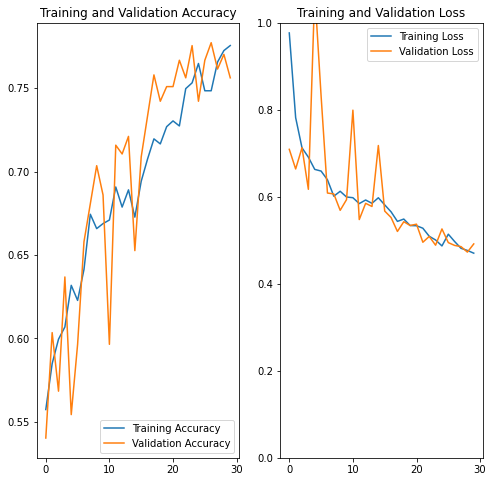

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.show()

In [51]:
model.save("models/" + NAME + ".h5")

In [52]:
model.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))

66/66 [==============================] - 24s 369ms/step - loss: 0.4957 - accuracy: 0.7695


[0.4956830143928528, 0.7695431709289551]

The accuracy of the model stayed almost the same with 76.95% compared to the model without dropout and batch normalization.

In [3]:
model_with_dropout_batchnorm = tf.keras.models.load_model("models/2_conv_128_nodes-Batchnorm-Dropout-20220219112148.h5")

# Transfer learning

After the exploration of a own deep learning model, the second aproach is transfer learning. Here a pre-trained model will be used and then based on that the images classified of our own data set. Xception is used for this task here.

In [228]:
base_model = tf.keras.applications.Xception(
            weights = "imagenet", ## load weights pre-trained on ImageNet
            input_shape = (Image_Width,Image_Height,Image_Channels),
            include_top=False
            )

83697664/83683744 [==============================] - 23s 0us/step


## Freeze the base_model

First the layers are freezed and will not be updated during the training.

In [291]:
base_model.trainable = False

In [292]:
inputs = tf.keras.Input(shape=(Image_Width,Image_Height,Image_Channels))

The weights of Xception (pre-trained) need to be normalized.

In [294]:
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()

In [295]:
mean = np.array([127.5]*3)
var = mean ** 2

In [296]:
## Scale the input

In [297]:
x = norm_layer(inputs)
#norm_layer.set_weights([mean, var])

In [298]:
from numpy import sqrt
norm_layer = (inputs - mean) / sqrt(var)

In [299]:
norm_layer

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'tf.math.truediv_6')>

In [300]:
x = base_model(x, training=False)

In [301]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) # regularize with dropout
outputs = tf.keras.layers.Dense(1)(x)

In [302]:
model = tf.keras.Model(inputs, outputs)

In [303]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
normalization_4 (Normalizati (None, 128, 128, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 2049      
Total params: 20,863,536
Trainable params: 2,049
Non-trainable params: 20,861,487
___________________________________________

In [304]:
model.compile(optimizer="adam", loss = "binary_crossentropy", metrics=["accuracy"])

In [305]:
epochs = 3

Here we can see, that the model did have a better accuracy, but the validation loss increased after the second epoch.

In [306]:
model.fit(train_generator, epochs=epochs, validation_data = validation_generator)

Epoch 1/3
155/155 [==============================] - 130s 821ms/step - loss: 1.7232 - accuracy: 0.8314 - val_loss: 0.7456 - val_accuracy: 0.9158
Epoch 2/3
155/155 [==============================] - 127s 822ms/step - loss: 1.3327 - accuracy: 0.8723 - val_loss: 0.7100 - val_accuracy: 0.9296
Epoch 3/3
155/155 [==============================] - 121s 783ms/step - loss: 2.2310 - accuracy: 0.8280 - val_loss: 1.7174 - val_accuracy: 0.8711


## Unfreeze the base_model

Here the layers will be updated during the training.

In [308]:
base_model.trainable = True
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
normalization_4 (Normalizati (None, 128, 128, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 2049      
Total params: 20,863,536
Trainable params: 20,809,001
Non-trainable params: 54,535
__________________________________________

The loss is set up according to the suggestion of the tensorflow documentation. With *from_logits=True* the model's prediction, i.e, a single floating-point which represents a value from [- infinity to infinity].

In [310]:
model.compile(
optimizer = tf.keras.optimizers.Adam(1e-5),
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=[tf.keras.metrics.BinaryAccuracy()],)

In [311]:
epochs = 2

In [312]:
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/2
155/155 [==============================] - 523s 3s/step - loss: 0.1925 - binary_accuracy: 0.9170 - val_loss: 0.1033 - val_binary_accuracy: 0.9519
Epoch 2/2
155/155 [==============================] - 474s 3s/step - loss: 0.1181 - binary_accuracy: 0.9518 - val_loss: 0.0748 - val_binary_accuracy: 0.9656


In [313]:
predictions = model.predict(test_generator)

In [3]:
#predictions

In [318]:
model.save("models/transfer_learning_trainables_true.h5")

In [40]:
transfer_learning_trainables_true = tf.keras.models.load_model('final_model/transfer_learning_trainables_true.h5')

With transfer learning the model takes a long time to train, but the results are very good. This model perform with an accuracy of 94.42% and also the loss is very low, compared to the models before.

In [41]:
transfer_learning_trainables_true.evaluate(test_generator, steps=np.ceil(nb_samples/batch_size))

66/66 [==============================] - 54s 604ms/step - loss: 0.1216 - binary_accuracy: 0.9442


[0.12161363661289215, 0.9441624283790588]

## Check out some predictions

Here we can see that the model precits many different kind of pictures correctly, even in one case, where also a girl is shown in the image, the classification is correct.

In [44]:
class_names = ["cat", "dog"]

Predictions:
 [0 0 1 1 0 0 1 1 0 0 1 0 0 1 0]
Labels:
 [1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.]


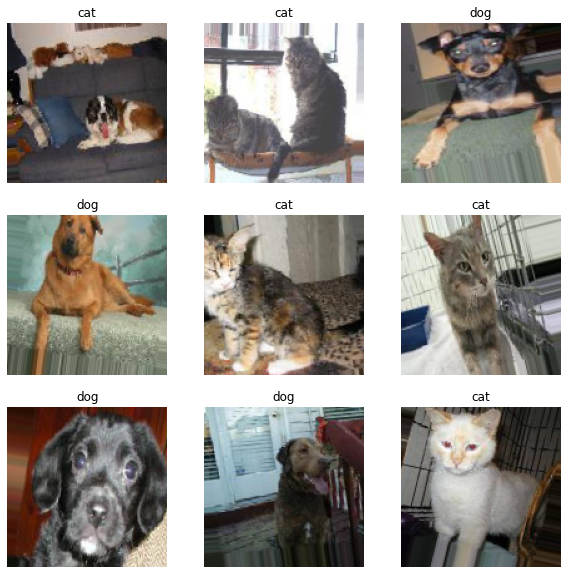

In [56]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_generator.next()
predictions = transfer_learning_trainables_true.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    plt.title(class_names[predictions[i]])
    plt.axis("off")

# Transfer learning 

Our next model is again a transfer learning model. While researching image processing, we came across the ResNet. The often used ResNet abbreviation stands for Residual Network. This is a neural network published by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in 2015 in their <a href="https://arxiv.org/abs/1512.03385">Research Paper</a>. The model achieved an error rate of only 3.57% and won several awards as a result. 

In [33]:
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Preparing the data

In [34]:
directory_train = "C:/Users/guido/switchdrive/3. Semester/DLB03 Deep Learning Bootcamp/Instruction material\Final_Data_Challenge/data/training_data"
directory_validation = "C:/Users/guido/switchdrive/3. Semester/DLB03 Deep Learning Bootcamp/Instruction material\Final_Data_Challenge/data/validation_data"

img_height,img_width = 150,150
batch_size = 32

In [35]:
data_training = tf.keras.utils.image_dataset_from_directory(
    directory_train,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 2907 files belonging to 2 classes.


In [36]:
data_validation = tf.keras.utils.image_dataset_from_directory(
    directory_validation,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 985 files belonging to 2 classes.


In [37]:
class_names = data_training.class_names
print(class_names)

['cat', 'dog']


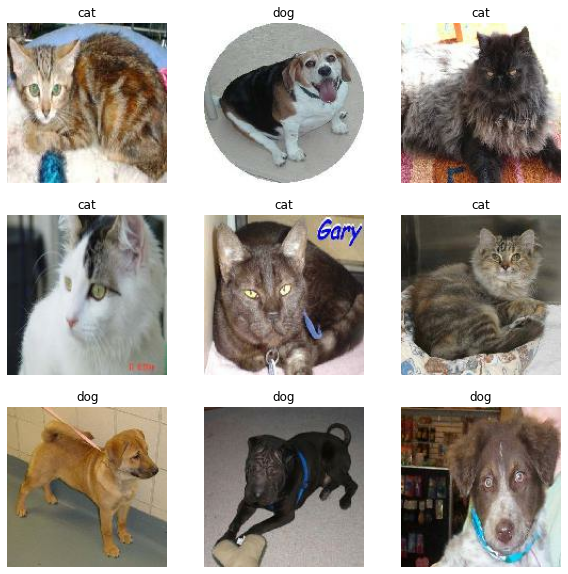

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data_training.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Training the model 

In [39]:
model = Sequential()

pretrained_model= keras.applications.ResNet50(include_top=False,
                   input_shape=(150,150,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))




In [40]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 1,050,114
Non-trainable params: 23,587,712
_________________________________________________________________


In [41]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
epochs = 10

history = model.fit(
  data_training,
  validation_data=data_validation,
  batch_size= 32,
  epochs=epochs
)

Epoch 1/10
91/91 [==============================] - 139s 2s/step - loss: 0.3923 - accuracy: 0.9071 - val_loss: 0.1137 - val_accuracy: 0.9513
Epoch 2/10
91/91 [==============================] - 148s 2s/step - loss: 0.0968 - accuracy: 0.9628 - val_loss: 0.1530 - val_accuracy: 0.9442
Epoch 3/10
91/91 [==============================] - 152s 2s/step - loss: 0.0670 - accuracy: 0.9725 - val_loss: 0.1478 - val_accuracy: 0.9431
Epoch 4/10
91/91 [==============================] - 157s 2s/step - loss: 0.0368 - accuracy: 0.9886 - val_loss: 0.1571 - val_accuracy: 0.9360
Epoch 5/10
91/91 [==============================] - 158s 2s/step - loss: 0.0207 - accuracy: 0.9942 - val_loss: 0.1613 - val_accuracy: 0.9421
Epoch 6/10
91/91 [==============================] - 158s 2s/step - loss: 0.0206 - accuracy: 0.9938 - val_loss: 0.1771 - val_accuracy: 0.9442
Epoch 7/10
91/91 [==============================] - 156s 2s/step - loss: 0.0093 - accuracy: 0.9983 - val_loss: 0.1447 - val_accuracy: 0.9482
Epoch 8/10
91

## Evaluate the model

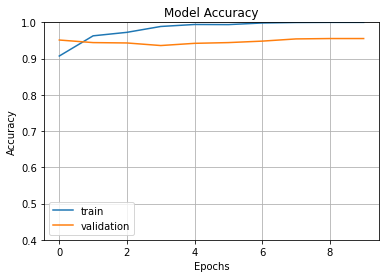

In [43]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

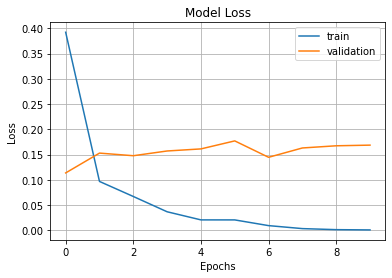

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## Save the model

In [45]:
history.model.save("models/resnet_model.h5")

In [46]:
history_dict = history.history

json.dump(history_dict, open("models/ResNet50.h5", 'w'))

# Conclusion 